# 

In [1]:
import spotipy
import numpy as np
import pandas as pd

from ipywidgets import widgets, Layout

from spotipy.oauth2 import SpotifyClientCredentials # To access authorised Spotify data


CLIENT_ID = '507eeae5f20d4bd1829af98a58746626'
CLIENT_SECRET = '59ccacf9fe04485390572018757845ba'

# API Login
client_credentials_manager = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager) #spotify object to access API

In [2]:
playlists = sp.user_playlists("tellezsanti")['items']

playlist_ids = {}

for playlist in playlists:
    playlist_ids[playlist['name']] = playlist['id']
    
plist_name = widgets.Select(
    options = playlist_ids.keys(),
    value = list(playlist_ids.keys())[0],
    description = 'Playlist:',
    disabled = False,
    layout = Layout(width='50%', height='180px')
)

display(plist_name)

Select(description='Playlist:', layout=Layout(height='180px', width='50%'), options=('Weekly Nishi', 'Fog Vall…

In [3]:
PLAYLIST_ID = playlist_ids[plist_name.value]

# Getting tracks of the playlist
tracks = sp.user_playlist_tracks(user = 'tellezsanti', playlist_id = PLAYLIST_ID)
tracks_uri_list = [x['track']['uri'] for x in tracks['items']]

# Getting features of tracks
features = []
for i in tracks_uri_list:
    features = features + sp.audio_features(i)

# Creating feature dataframe
cols_to_drop = ['id', 'analysis_url', 'key', 'time_signature', 'track_href', 'type', 'uri', 'mode', 'duration_ms']
features_df = pd.DataFrame(features).drop(cols_to_drop, axis=1)

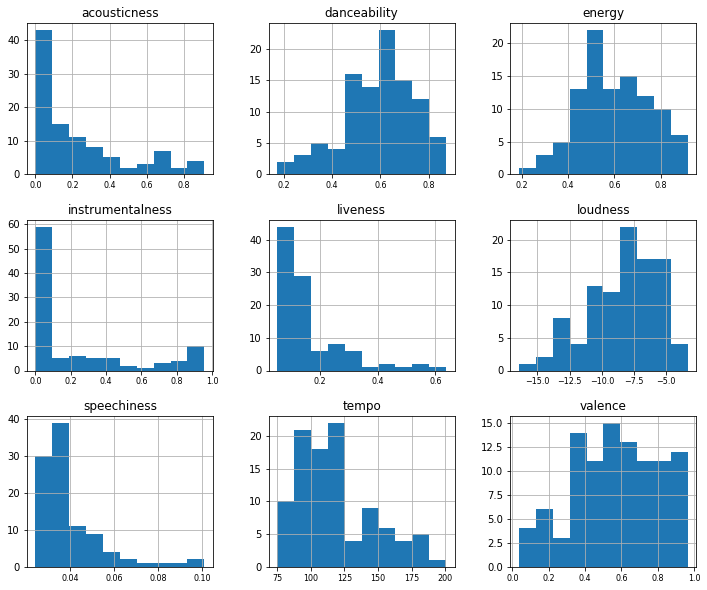

In [4]:
features_df.hist(xlabelsize=8, figsize=(12,10));

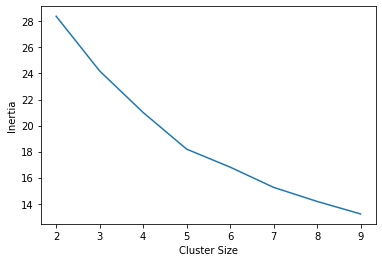

In [5]:
from sklearn.cluster import KMeans

# Scaling
for col in ['loudness', 'tempo']:
    features_df[col] = ((features_df[col] - features_df[col].min()) / (features_df[col].max() - features_df[col].min()))

# Determining the cluster size
score_list = []
for i in range(2,10):
    kmeans_model = KMeans(n_clusters=i, random_state=3).fit(features_df)
    preds = kmeans_model.predict(features_df)
    score_list.append(kmeans_model.inertia_)

# Visualization of different cluster size performations
pd.DataFrame(score_list, index=range(2, 10)).plot(legend=False).set(xlabel="Cluster Size", ylabel="Inertia")

# Training and Predicting
kmeans_model = KMeans(n_clusters = 5, random_state=3).fit(features_df)
preds = kmeans_model.predict(features_df)

In [6]:
# Extracting song and artist names
songs = [x['track']['name'] for x in tracks['items']]
artists = [x['track']['artists'] for x in tracks['items']]

# Concatenating multiple artist names
artist_list = []
for group in artists:
    artist_group = []
    for person in group:
        artist_group.append(person['name'])
    artist_list.append(', '.join(artist_group))

# Adding predictions to dataframe
features_df['cluster'] = preds

# Grouping clusters to see the averages
clusters = features_df.groupby('cluster').agg('mean')
clusters

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,0.468333,0.724800,0.813399,0.039480,0.108356,0.161172,0.160213,0.533133,0.728777
1,0.663556,0.626556,0.603644,0.041259,0.115005,0.097130,0.120426,0.787519,0.284692
2,0.624550,0.629200,0.525195,0.044075,0.284217,0.811100,0.185760,0.653100,0.263469
3,0.649250,0.493917,0.592811,0.034758,0.717167,0.079696,0.199083,0.543100,0.262980
4,0.548385,0.525115,0.568354,0.036412,0.155123,0.027395,0.172450,0.325823,0.304276


In [7]:
# listing clusters

song_clusters = np.concatenate((np.array(songs)[:, np.newaxis], preds[:, np.newaxis]), axis = 1)

for c in np.unique(song_clusters[:, 1]):
    print(c)
    print(list(song_clusters[song_clusters[:, 1] == c, 0]))

0
['Down the Line', 'Coins', 'Garden', 'The Adults Are Talking', 'I Follow You', 'Nothing in This Town', 'Riding Solo', 'Questioning My Mind', 'Fly Out West', 'A Pill to Crush', 'Are You OK?', 'A la plage', 'Clouds of Your Mind', 'Charcoal Baby', 'Someday Soon']
1
['Friends', 'Time (You and I)', 'Guts', 'Stomp the Yard', 'Going on a Chill Walk', 'Wasting Time', 'Someone To Spend Time With', 'Moving On', 'Crimson & Clover', 'What Is Love? Tell Me, Is It Easy?', 'Sunflower (feat. Steve Lacy)', 'Sensitivity', 'Ruin Your Night', 'Fruit', 'Cacti For Clothes', 'Be Proud of Your Kids', 'Your Dog', 'Pelota', 'Lonely Type', 'Drugs', 'Ozma', '29 Palms', 'Honey', 'Champagne Coast', "Heaven's Only Wishful", 'Man on the Moon', 'Guilty']
2
['Some Sunsick Day', 'Echo Park', 'White Gloves', 'The Infamous Bill', 'Dern Kala', 'Two Fish and an Elephant', 'Indian Food', 'Horizon', 'Marco Polo', 'Geology', 'Staring At The Sun', 'Shirim', "So We Won't Forget", 'Flying', 'Lover Boy Pt. II', 'Canta', 'These S